In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

#### Part C - Write down the equations for two differentlinear models such that one of the models can be derived from the other by adding an additional term

model 1: $ mpg = \beta_0 + \beta_1\times(horsepower) + \beta_2\times(weight) + \beta_3\times(acceleration) $  
model 2: $ mpg = \beta_0 + \beta_1\times(horsepower) + \beta_2\times(weight) + \beta_3\times(acceleration) + \beta_4\times(displacement) $

#### Read The Data

In [246]:
header = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
input_data = pd.read_csv('auto-mpg.data', names=header)

In [247]:
input_data.loc[:5]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500


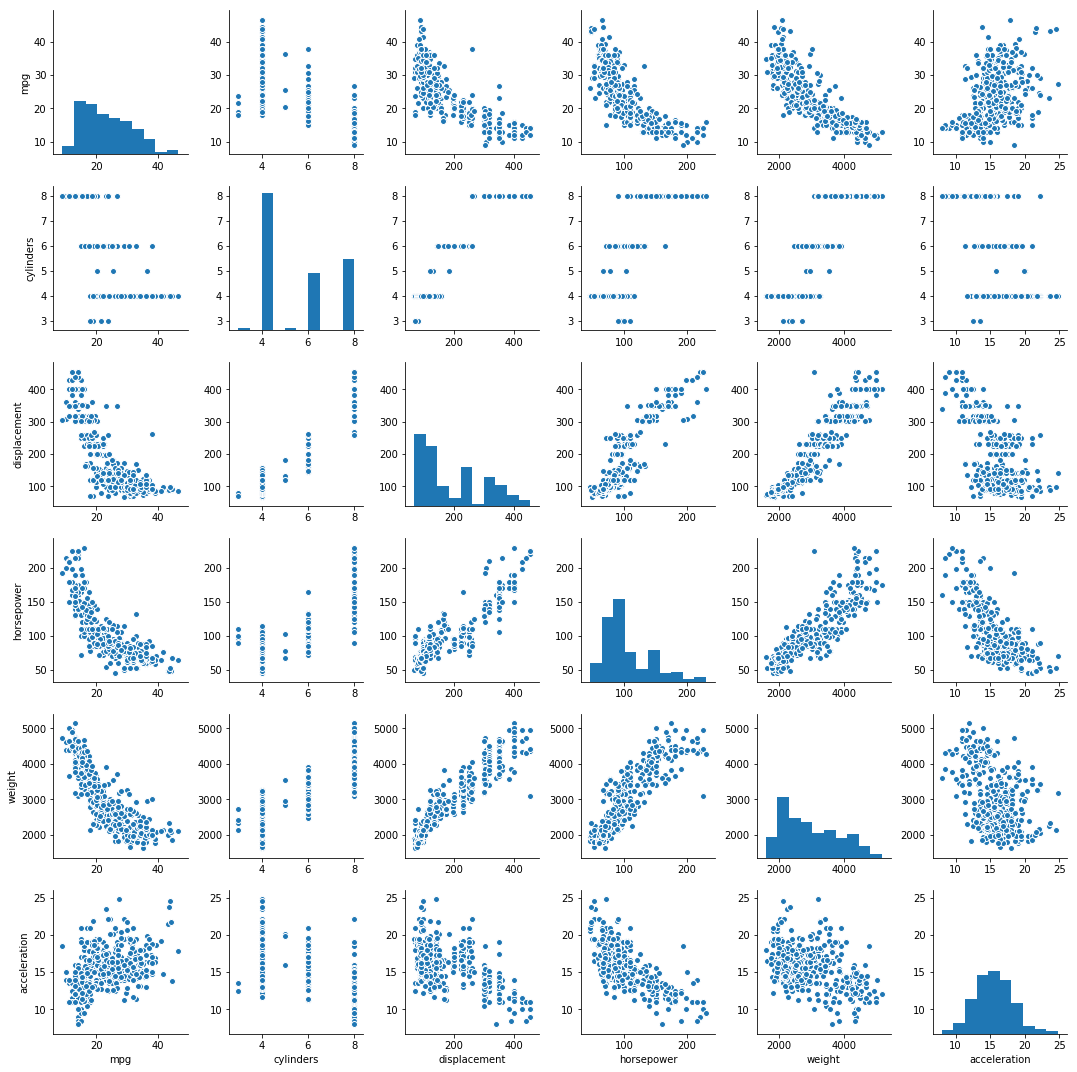

In [277]:
sns.pairplot(input_data[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']].dropna())

#### Preprocess the data

In [278]:
input_data = input_data.dropna()

model1_data = input_data[['mpg', 'horsepower', 'weight', 'acceleration']]
model2_data = input_data[['mpg', 'horsepower', 'weight', 'acceleration', 'displacement']]

#### Random Subsampling Approach

In [279]:
def random_subsampling(input_data, k):
    
    result = []
    
    for i in range(0, k):
        training_set = input_data.sample(frac=0.8)

        test_set_index = input_data.index.difference(training_set.index)
        test_set = input_data.loc[test_set_index]

        # Get the regressors matrix
        # Ignore the last column which contains the name of the cars
        df_X = training_set[training_set.columns.tolist()[1:-1]]
        df_X = df_X.astype(float)
        X = np.mat(DataFrame.as_matrix(df_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((X.shape[0],1))
        X = np.hstack((bias_vector, X))

        # Get the response vector
        Y = np.mat(DataFrame.as_matrix(training_set[training_set.columns.tolist()[0]])).T
        Y.astype(float)
    
        # Create a linear regression model
        lr = linear_model.LinearRegression()

        # cross_val_predict returns an array of the same size as `y` where each entry
        # is a prediction obtained by cross validation:
        predicted = lr.fit(X,Y)
    
        # Test the fitted model
        test_X = test_set[test_set.columns.tolist()[1:-1]].astype(float)
        test_X = np.mat(DataFrame.as_matrix(test_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((test_X.shape[0],1))
        test_X = np.hstack((bias_vector, test_X))
    
        # Get the response vector of test set
        test_Y = np.mat(DataFrame.as_matrix(test_set[test_set.columns.tolist()[0]])).T
        test_Y = test_Y.astype(float)
    
        # Make predictions using the testing set
        mpg_pred = lr.predict(test_X)

        # The mean squared error
        print("Mean squared error: %.2f" % mean_squared_error(test_Y, mpg_pred))
        result.append(mean_squared_error(test_Y, mpg_pred))              
    return result

In [280]:
# Execute random_subsampling on model 1
rss_msres_model1 = random_subsampling(model1_data, 10)

Mean squared error: 14.31
Mean squared error: 19.84
Mean squared error: 19.89
Mean squared error: 13.16
Mean squared error: 22.09
Mean squared error: 26.45
Mean squared error: 22.98
Mean squared error: 19.97
Mean squared error: 14.12
Mean squared error: 17.93


In [281]:
# Execute random_subsampling on model 2
rss_msres_model2 = random_subsampling(model2_data, 10)

Mean squared error: 20.66
Mean squared error: 15.78
Mean squared error: 16.01
Mean squared error: 17.31
Mean squared error: 16.88
Mean squared error: 18.96
Mean squared error: 21.07
Mean squared error: 13.55
Mean squared error: 14.50
Mean squared error: 18.45


#### K-Fold Cross Validation Approach

In [282]:
def k_fold_cross_validation(training_set, k):
    
    result = []
    
    # Partition into k parts
    permuted_indices = np.random.permutation(len(training_set))
    dfs = []
    for i in range(k):
        dfs.append(training_set.iloc[permuted_indices[i::k]])
    
    # Perform K-Fold cross validation
    for i in range(k):
        
        # Get training set
        training_set = []
        for j in range(k):
            if j != i:
                training_set.append(dfs[j])
        training_set = pd.concat(training_set)
        
        # Get test set
        test_set = dfs[i]
        
        # Get the regressors matrix
        # Ignore the last column which contains the name of the cars
        df_X = training_set[training_set.columns.tolist()[1:-1]]
        df_X = df_X.astype(float)
        X = np.mat(DataFrame.as_matrix(df_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((X.shape[0],1))
        X = np.hstack((bias_vector, X))

        # Get the response vector
        Y = np.mat(DataFrame.as_matrix(training_set[training_set.columns.tolist()[0]])).T
        Y.astype(float)
    
        # Create a linear regression model
        lr = linear_model.LinearRegression()

        # cross_val_predict returns an array of the same size as `y` where each entry
        # is a prediction obtained by cross validation:
        predicted = lr.fit(X,Y)
    
        # Test the fitted model
        test_X = test_set[test_set.columns.tolist()[1:-1]].astype(float)
        test_X = np.mat(DataFrame.as_matrix(test_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((test_X.shape[0],1))
        test_X = np.hstack((bias_vector, test_X))
    
        # Get the response vector of test set
        test_Y = np.mat(DataFrame.as_matrix(test_set[test_set.columns.tolist()[0]])).T
        test_Y = test_Y.astype(float)
    
        # Make predictions using the testing set
        mpg_pred = lr.predict(test_X)

        # The mean squared error
        print("Mean squared error: %.2f" % mean_squared_error(test_Y, mpg_pred))
        result.append(mean_squared_error(test_Y, mpg_pred))
    return result

In [283]:
# K-Fold cross validation on the first model
kcv_msres_model1 = k_fold_cross_validation(model1_data, 10)

Mean squared error: 23.38
Mean squared error: 14.70
Mean squared error: 23.14
Mean squared error: 14.39
Mean squared error: 12.14
Mean squared error: 17.12
Mean squared error: 13.46
Mean squared error: 16.79
Mean squared error: 28.22
Mean squared error: 17.33


In [284]:
# K-Fold cross validation on the second model
kcv_msres_model2 = k_fold_cross_validation(model2_data, 10)

Mean squared error: 10.72
Mean squared error: 15.26
Mean squared error: 25.73
Mean squared error: 19.82
Mean squared error: 26.53
Mean squared error: 17.02
Mean squared error: 14.79
Mean squared error: 20.47
Mean squared error: 17.72
Mean squared error: 15.74


#### LOOCV (Leave-one-out cross-validation) Approach

In [285]:
def loocv(input_data):
    
    SSRes = 0
    
    # Perform LOOCV
    for i in range(0, len(input_data)):
        training_set = input_data.drop(i)
        
        # Get the regressors matrix
        # Ignore the last column which contains the name of the cars
        df_X = training_set[training_set.columns.tolist()[1:-1]]
        df_X = df_X.astype(float)
        X = np.mat(DataFrame.as_matrix(df_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((X.shape[0],1))
        X = np.hstack((bias_vector, X))

        # Get the response vector
        Y = np.mat(DataFrame.as_matrix(training_set[training_set.columns.tolist()[0]])).T
        Y.astype(float)
    
        # Create a linear regression model
        lr = linear_model.LinearRegression()

        # cross_val_predict returns an array of the same size as `y` where each entry
        # is a prediction obtained by cross validation:
        predicted = lr.fit(X,Y)
    
        # Get test set
        test_set = input_data.loc[[i]]
    
        # Test the fitted model
        test_X = test_set[test_set.columns.tolist()[1:-1]].astype(float)
        test_X = np.mat(DataFrame.as_matrix(test_X))

        # Prepend the bias column to the matrix X
        bias_vector = np.ones((test_X.shape[0],1))
        test_X = np.hstack((bias_vector, test_X))
    
        # Get the response vector of test set
        test_Y = np.mat(DataFrame.as_matrix(test_set[test_set.columns.tolist()[0]])).T
        test_Y = test_Y.astype(float)
    
        # Make predictions using the testing set
        mpg_pred = lr.predict(test_X)
        
        SSRes += mean_squared_error(test_Y, mpg_pred)
        
    MSRes = SSRes / len(input_data)
    print("Mean squared error: %.2f" % MSRes)
    
    return MSRes

In [286]:
# Perform LOOCV on Model 1 Data
loocv_model1 = loocv(model1_data)

Mean squared error: 18.11


In [287]:
# Perform LOOCV on Model 2 Data
loocv_model2 = loocv(model2_data)

Mean squared error: 18.26


#### Part E - Explain what these three approaches: random subsampling, k-fold CV and LOOCV are trying to accomplish.

All of these 3 approaches are used to estimate the performance of the chosen model. The performance is measured by the true error rate on the entire population, however, since we don't have access to the entire population, these methods give us an estimation of the true error rate at the expense of more computations

#### Part F - Plot a figure containing two boxplots: one with the 10 MSEs you obtained for one of the models in part (1da), and the other with the 10 MSEs that you obtained for the other model in part (1da).

In [288]:
def box_plot(model1_msres, model2_msres):

    df3 = DataFrame(model1_msres , columns=['MSRes'])
    df4 = DataFrame(np.full((len(model1_msres), 1), "Model 1"), columns=['Model'])

    df = DataFrame(model2_msres , columns=['MSRes'])
    df2 = DataFrame(np.full((len(model2_msres), 1), "Model 2"), columns=['Model'])

    boxplot_data = pd.concat([df3.join(df4), df.join(df2)])
    
    ax = sns.boxplot(x="Model", y="MSRes", data=boxplot_data)

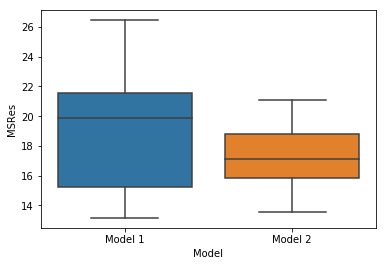

In [289]:
box_plot(rss_msres_model1, rss_msres_model2)

#### Part G - Plot a figure containing two boxplots: one with the 10 MSEs you obtained for one of the models in part (1db), and the other with the 10 MSEs that you obtained for the other model in part (1db). In each of these three approaches, output the MSE for both models.

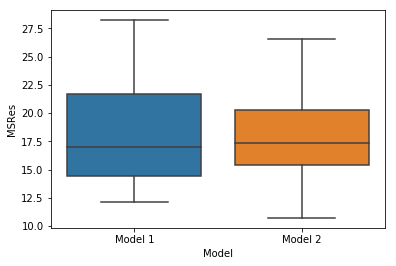

In [290]:
box_plot(kcv_msres_model1, kcv_msres_model2)

In [291]:
print("Random Subsampling Approach")
print("MSRes of model 1: %.4f" % np.mean(np.array(rss_msres_model1)))
print("MSRes of model 2: %.4f\n" % np.mean(np.array(rss_msres_model2)))

print("K-Fold Cross-Validation Approach")
print("MSRes of model 1: %.4f" % np.mean(np.array(kcv_msres_model1)))
print("MSRes of model 2: %.4f\n" % np.mean(np.array(kcv_msres_model2)))

print("LOOCV Approach")
print("MSRes of model 1: %.4f" % np.mean(np.array(loocv_model1)))
print("MSRes of model 2: %.4f\n" % np.mean(np.array(loocv_model2)))

Random Subsampling Approach
MSRes of model 1: 19.0741
MSRes of model 2: 17.3173

K-Fold Cross-Validation Approach
MSRes of model 1: 18.0681
MSRes of model 2: 18.3802

LOOCV Approach
MSRes of model 1: 18.1129
MSRes of model 2: 18.2560



#### Part H - Based on the figures and results you obtained in parts (1d) to (1f), which of the models would you pick? Why? You need to provide enough details in your answer. It cannot simply be: “Choose model two. Less error.”

It's really hard to say whether model 1 or model 2 is better based on the mean squared error obtained from all 3 approaches because they're approximately the same. Based on the figures above, it might be better (but not strongly confident) to pick model 2 because of the following reasons:  

+ The figure of the random subsampling approach shows the model 2 has a lower variance of MSRes than model 1.
+ Both of the figure show that it seems like model 2 has a smaller interquartile range, that is, the MSE in model 2 are densely populated smaller range than those in model 1